Playing around with new noise:

In [1]:
import numpy as np

In [2]:
L = 100
M = 10

In [3]:
org_survival = 1/np.e
w = -1/(M * np.log(np.log(1/org_survival)/L)) # this is fixed, based on giving 1/e probability of survival
print(w)

0.021714724095162594


In [4]:
msg_probs = [2 ** (-j) for j in range(M)]
msg_probs /= np.sum(msg_probs)

In [5]:
precision = 0.00001

### One code:

In [6]:
def score_fn_lagrangian(msg_probs, lambda_val, w):
    
    """
    Computes 
    
    Parameters:
    -------
    
    msg_probs: a list of non-negative real numbers summing to 1. These are the g_j's.
    lambda_val: a non-negative real number
    w: a non-negative real number. This is the noise "width"
    
    Returns:
    --------
    a (negative) real number, which is the log likelihood of 
    """
    prod = 1
    for j in range(len(msg_probs)):
        prod *= msg_probs[j] / (lambda_val * w) + 1
    return np.log(prod)

def lambda_search(msg_probs, w, lambda_high, lambda_low):
    
    lambda_val = (lambda_high + lambda_low) / 2.0
    score = score_fn_lagrangian(msg_probs, lambda_val, w)
    if abs(score - 1/w) < precision:
        return lambda_val
    elif score > 1/w:
        # increase lambda
        return lambda_search(msg_probs, w, lambda_high, lambda_val)
    else:
        # decrease lambda
        return lambda_search(msg_probs, w, lambda_val, lambda_low)
    
def optimize(msg_probs, w):
    lambda_val = lambda_search(msg_probs, w, 1000, 0)
    a_arr = [w * np.log(msg_probs[j]/ (lambda_val * w) + 1) for j in range(M)]
    return a_arr

In [7]:
# these functions are just to check that there is a significant difference in performance in good and bad environments

def obj_function(msg_probs, a_arr, w):
    return L * sum([msg_probs[j] * np.log(1 - np.exp(-a_arr[j]/w)) for j in range(M)])

def prob_function(msg_probs, a_arr, w):
    return np.exp(obj_function(msg_probs, a_arr, w))

One code, two environments:

In [8]:
a_precision = 0.001
lambda_precision = 0.001

def find_a(L, lambda_val, high_a, low_a, msg_prob, w1, w2, p):
    a = (high_a + low_a) / 2.0
    rhs = ((L * p * msg_prob) / (np.exp(a / w1) - 1)) / w1 + ((L * (1 - p) * msg_prob) / (np.exp(a / w2) - 1)) / w2
    if abs(rhs - lambda_val) < a_precision:
        return a
    elif rhs > lambda_val:
        # increase a_j
        return find_a(L, lambda_val, high_a, a, msg_prob, w1, w2, p)
    else:
        return find_a(L, lambda_val, a, low_a, msg_prob, w1, w2, p)
    

def optimize_multiple_env(msg_probs, lambda_low, lambda_high, w1, w2, p):
    
    """
    Noise is w1 with probability p and w2 with probability 1-p. Changing the order of w1 and w2 gives different answers!
    """
    
    lambda_val = (lambda_low + lambda_high) / 2.0
    
    # find a_j's corresponding to that lambda
    
    a_vals = [find_a(L, lambda_val, 100 * w, 0, msg_probs[j], w1, w2, p) for j in range(M)]
    a_vals_sum = sum(a_vals)
    
    if abs(a_vals_sum - 1.0) < lambda_precision:
        return a_vals
    elif a_vals_sum > 1.0:
        # lambda is making a_vals become too high
        # so make lambda higher, so a_vals become lower to compensate
        return optimize_multiple_env(msg_probs, lambda_val, lambda_high, w1, w2, p)
    else:
        return optimize_multiple_env(msg_probs, lambda_low, lambda_val, w1, w2, p)

### Bet hedging:

In [9]:
pvals = np.arange(0.01, 1.0, 0.01)

In [10]:
def bet_hedging_obj_fn(s_gg, s_bg, s_bb, s_gb, p, lambda_popn):
    
    """
    Returns the value of objective function given lambda, s_gg, s_bg, s_bb and s_gb where these variables are as defined above. p is the probability of good environment
    """
    
    return ((lambda_popn * s_gg + (1 - lambda_popn) * s_bg) ** p) * ((lambda_popn * s_gb + (1 - lambda_popn) * s_bb) ** (1 - p))

def one_code_obj_fn(msg_probs, a_arr, w1, w2, p):
    
    """
    Returns the objective function value for the case with many environments, one code.
    
    Inputs:
    
    msg_probs are the message probabilities
    a_arr is the output of the optimize_multiple_env() function
    w1 is the noise width of the good environment
    w2 is the noise width of the bad environment
    p is the probability of occurrence of the good environment
    """
    
    perf_good_env = prob_function(msg_probs, a_arr, w1)
    perf_bad_env = prob_function(msg_probs, a_arr, w2)
    
    return (perf_good_env ** p) * (perf_bad_env ** (1 - p))

In [11]:
def find_bet_hedging_perf(good_w, bad_w, p):
    
    s_gg = prob_function(msg_probs, optimize(msg_probs, good_w), good_w) # prepares for a good environment and is in a good environment
    s_gb = prob_function(msg_probs, optimize(msg_probs, good_w), bad_w) # prepares for good, ends up in bad
    s_bg = prob_function(msg_probs, optimize(msg_probs, bad_w), good_w) # prepares for bad, ends up in good
    s_bb = prob_function(msg_probs, optimize(msg_probs, bad_w), bad_w) # prepares for bad, ends up in bad
    
    # optimize for lambda using Lagrange multipliers; encode the constraint that 0 <= lambda <= 1

    A = p * (s_gg - s_bg)
    B = (1 - p) * (s_bb - s_gb)

    num = B * s_bg - A * s_bb
    denom = A * (s_gb - s_bb) - B * (s_gg - s_bg)

    lambda_popn_lagrange = num / denom

    # this lambda might violate constraints
    # so check that

    if lambda_popn_lagrange < 0 or lambda_popn_lagrange > 1:
        # lambda is outside the range
        # so maximum is either at 0 or 1
        # assign lambda as 0 or 1, whichever results in greater function value
        lambda_popn_lagrange = 0.0

    lambda_popn_lagrange_val = bet_hedging_obj_fn(s_gg, s_bg, s_bb, s_gb, p, lambda_popn_lagrange)

    # you have to check the value of the function at this point, lambda = 0 and lambda = 1

    if lambda_popn_lagrange_val <= bet_hedging_obj_fn(s_gg, s_bg, s_bb, s_gb, p, 0):
        lambda_popn_lagrange = 0.0
        lambda_popn_lagrange_val = bet_hedging_obj_fn(s_gg, s_bg, s_bb, s_gb, p, 0)
    if lambda_popn_lagrange_val <= bet_hedging_obj_fn(s_gg, s_bg, s_bb, s_gb, p, 1):
        lambda_popn_lagrange = 1.0
        lambda_popn_lagrange_val = bet_hedging_obj_fn(s_gg, s_bg, s_bb, s_gb, p, 1)
        
    return lambda_popn_lagrange, lambda_popn_lagrange_val

def find_one_code_perf(msg_probs, good_w, bad_w, p):
    
    lambda_low = 0
    lambda_high = 10000
    
    one_code_a_arr = optimize_multiple_env(msg_probs, lambda_low, lambda_high, good_w, bad_w, p)
    one_code_perf = one_code_obj_fn(msg_probs, one_code_a_arr, good_w, bad_w, p)
    
    return one_code_perf

def compare_perf(msg_probs, good_w, bad_w):

    bet_hedging_perf_arr = []
    one_code_perf_arr = []
    lambda_arr = []

    for p in pvals:

        lambda_popn, bet_hedging_perf = find_bet_hedging_perf(good_w, bad_w, p)
        one_code_perf = find_one_code_perf(msg_probs, good_w, bad_w, p)

        bet_hedging_perf_arr.append(bet_hedging_perf)
        one_code_perf_arr.append(one_code_perf)
        lambda_arr.append(lambda_popn)
        
    return bet_hedging_perf_arr, one_code_perf_arr, lambda_arr

# ------------------------------------------------------------------------------------------------

Some space to play around with the above functions:

In [19]:
# w_epsilon = 0.1 * w # this will cause performance to be not so different
w_epsilon = 0.4 * w # this will cause performance to be different
# w_epsilon = 0.75 * w # this will cause performance to be very different
# w_epsilon = 0.9 * w # this will cause performance to be very very different

print('w:', w)
print('w epsilon:', w_epsilon)
bad_w = w + w_epsilon
good_w = w - w_epsilon
print('Bad env w:', bad_w)
print('Good env w:', good_w)

w: 0.021714724095162594
w epsilon: 0.008685889638065039
Bad env w: 0.03040061373322763
Good env w: 0.013028834457097556


In [20]:
s_gg = prob_function(msg_probs, optimize(msg_probs, good_w), good_w) # prepares for a good environment and is in a good environment
s_gb = prob_function(msg_probs, optimize(msg_probs, good_w), bad_w) # prepares for good, ends up in bad
s_bg = prob_function(msg_probs, optimize(msg_probs, bad_w), good_w) # prepares for bad, ends up in good
s_bb = prob_function(msg_probs, optimize(msg_probs, bad_w), bad_w) # prepares for bad, ends up in bad

# should print in decreasing order, else something is most likely wrong

print('s_gg:', s_gg)
print('s_bg:', s_bg)
print('s_bb:', s_bb)
print('s_gb:', s_gb)

s_gg: 0.9897752668289228
s_bg: 0.9480224151449897
s_bb: 0.4093275418647193
s_gb: 0.22593508536602147


In [21]:
p = 0.5
print(find_bet_hedging_perf(good_w, bad_w, p))
print(find_one_code_perf(msg_probs, good_w, bad_w, p))

(0.0, 0.6229379462064846)
0.6258744961850137


# --------------------------------------------------------------------------------------------------

Do a test run for the graph plotting:

In [23]:
import matplotlib.pyplot as plt
# plt.rcParams['text.usetex'] = True
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 12})

In [ ]:
# just to check if there's a significant difference if the organism prepares for a good environment but operates in a bad environment

optimal_perf = prob_function(msg_probs, optimize(msg_probs, bad_w), bad_w)
org_perf = prob_function(msg_probs, optimize(msg_probs, good_w), bad_w)
perf_ratio = org_perf / optimal_perf
print(perf_ratio)

In [26]:
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams.update({'font.size': 12})

<Figure size 720x720 with 0 Axes>

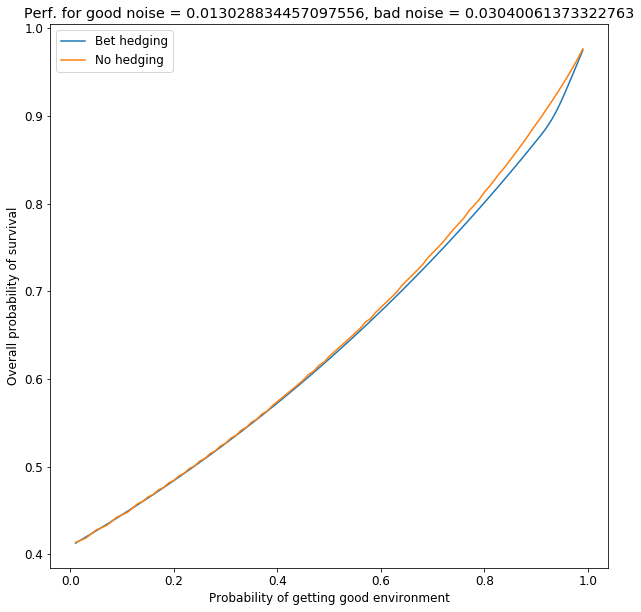

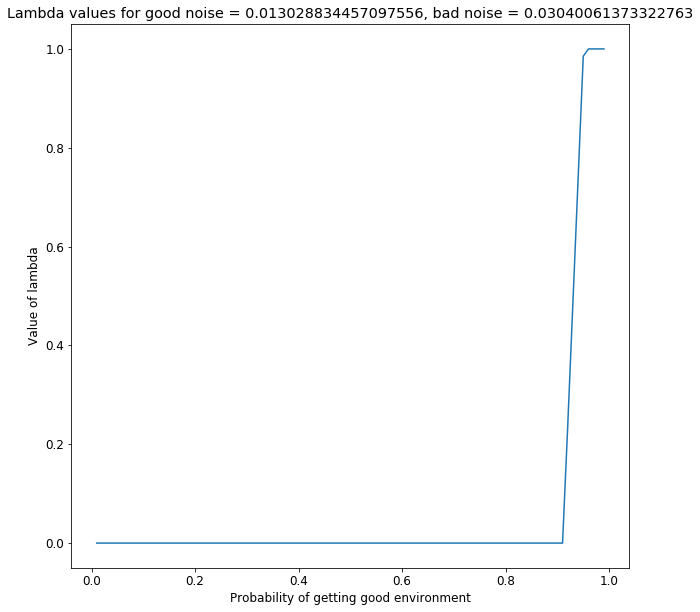

<Figure size 720x720 with 0 Axes>

In [27]:
bet_hedging_perf_arr, one_code_perf_arr, lambda_arr = compare_perf(msg_probs, good_w, bad_w)

plt.figure()

plt.plot(pvals, bet_hedging_perf_arr)
plt.plot(pvals, one_code_perf_arr)

plt.title('Perf. for good noise = ' + str(good_w) + ', bad noise = ' + str(bad_w))
plt.xlabel('Probability of getting good environment')
plt.ylabel('Overall probability of survival')
plt.legend(['Bet hedging', 'No hedging'])

plt.figure()

plt.plot(pvals, lambda_arr)
plt.title('Lambda values for good noise = ' + str(good_w) + ', bad noise = ' + str(bad_w))
plt.xlabel('Probability of getting good environment')
plt.ylabel('Value of lambda')

plt.figure()

In [ ]:
print(bet_hedging_perf_arr)

In [ ]:
print(one_code_perf_arr)

### Several plots for different noise widths:

In [ ]:
factors = np.linspace(0.1, 0.90, 20)
pvals = np.arange(0.01, 0.99, 0.005)

for factor in factors:
    print('Factor:', factor)
    w_epsilon = factor * w # this will cause performance to be different
    print('w epsilon:', w_epsilon)
    bad_w = w + w_epsilon
    good_w = w - w_epsilon
    print('Bad env w:', bad_w)
    print('Good env w:', good_w)
    
    bet_hedging_perf_arr, one_code_perf_arr, lambda_arr = compare_perf(msg_probs, good_w, bad_w)
    
#     plt.plot(pvals, lambda_arr)
#     plt.title('Lambda values for good noise = ' + str(good_w) + ', bad noise = ' + str(bad_w))
#     plt.xlabel('Probability of getting good environment')
#     plt.ylabel('Value of lambda')
#     plt.figure()

    plt.plot(pvals, bet_hedging_perf_arr)
    plt.plot(pvals, one_code_perf_arr)
    plt.plot(pvals, lambda_arr)

    plt.title('Perf. for good noise = ' + str(good_w) + ', bad noise = ' + str(bad_w))
    plt.xlabel('Probability of getting good environment')
    plt.ylabel('Overall probability of survival')
    plt.legend(['Bet hedging', 'No hedging', 'Lambda'])
#     plt.savefig('Plots/BetHedgingVsOneCodeSmallNoise/factor-' + str(factor) + '.svg', format = 'svg')
    
    plt.show()
    plt.figure()